In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.models.signature import infer_signature

from sklearn.model_selection import train_test_split,GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

### Import

In [3]:
df = pd.read_csv('train_preprocessed_noNA.csv')
df.set_index('SK_ID_CURR', inplace=True)

In [4]:
df_sample = df.copy()
df_sample = df.sample(frac=0.25)
X = df_sample.drop('TARGET', axis=1)
# Reformatage colonnes pour LightGBM
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df_sample['TARGET'].tolist()

### Train-Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=123)
print('Train :', X_train.shape)
print('Test :', X_test.shape)

# creating the evaluation dataframe
eval_data = X_test.copy()
eval_data['target'] = y_test

Train : (61501, 590)
Test : (15376, 590)


In [6]:
print('y sample vc :', pd.Series(y).value_counts(normalize=True))

y sample vc : 0    0.919157
1    0.080843
dtype: float64


In [7]:
max_pos = pd.Series(y_test).value_counts()[1]*10
print('Max score métier', max_pos/len(y_test))

Max score métier 0.8084027055150884


In [8]:
pd.Series(y_test).value_counts()

0    14133
1     1243
dtype: int64

### Scorer

In [9]:
def scorer_metier(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()   
    score_false = 10*fn+fp
    score = score_false/(tn+fp+fn+tp)
    return score

custom_scorer = metrics.make_scorer(score_func=scorer_metier, 
                                    greater_is_better=False, 
                                    needs_proba=False)

### Fonctions run MlFlow

In [10]:
mlflow.sklearn.autolog()
    
# Ajout score métier à fonction d'évaluation
def score_metier(eval_df, builtin_metrics):
    tn, fp, fn, tp = metrics.confusion_matrix(eval_df['target'], eval_df['prediction']).ravel()   
    score_false = 10*fn+fp
    score = score_false/(tn+fp+fn+tp)
    return score

# Customs metrics
score_metier_mlf = mlflow.models.make_metric(eval_fn=score_metier,
                                                 greater_is_better=False)
# Function évaluation, à call after model fit
def eval_fn(model) :
    mlflow.sklearn.log_model(model, 'model')
    model_uri = mlflow.get_artifact_uri('model')
    result = mlflow.evaluate(
            model=model_uri,
            data=eval_data,
            targets='target',
            model_type='classifier',
            evaluators=['default'],
            custom_metrics=[score_metier_mlf],
            )
    
# Evaluation run (hors gscv)
def evaluation_run(run_name, model):
    with mlflow.start_run(run_name=run_name) as run:
        eval_fn(model)

# Run pour gscv
def gscv_run(nom_run, estimateur, params) :
    with mlflow.start_run(run_name=nom_run, nested=True) as run:       
        # Pipeline d'ajout de valeurs synthétiques SMOTE au train set
        steps = [('oversampling', SMOTE()), ('model', estimateur)]
        model_pipeline = Pipeline(steps=steps)
        # Stratified kFolds 
        cv = StratifiedKFold(n_splits=5)

        grid = GridSearchCV(estimator=model_pipeline,
                    param_grid=params,
                    scoring=custom_scorer,
                    cv=cv, 
                    verbose=3
                   )
        grid.fit(X_train, y_train)
        
        # Eval
        eval_fn(grid)

# Models Tests

### DummyClassifier

In [10]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X, y)
evaluation_run('DummyClassifier', dummy_clf)

2023/08/08 18:11:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '24981cbe0adf4d4297bf7577d9aeae04', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/08 18:11:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Va

<Figure size 1050x700 with 0 Axes>

### LogisticRegression

In [11]:
nom_run = 'LogisticReg_GSCV'
estimateur = LogisticRegression(max_iter=1000)
params = params={'model__tol' : [0.001, 0.01],
                 'model__C' : [0.01, 0.1, 1, 10], 
                'model__solver' : ['lbfgs', 'newton-cholesky']}

gscv_run(nom_run, estimateur, params) 

2023/08/08 18:14:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.001;, score=-0.724 total time=  40.4s
[CV 2/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.001;, score=-0.722 total time=  42.9s
[CV 3/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.001;, score=-0.822 total time=   7.8s
[CV 4/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.001;, score=-0.721 total time=  32.1s
[CV 5/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.001;, score=-0.740 total time=  26.7s
[CV 1/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.01;, score=-0.729 total time=  28.5s
[CV 2/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.01;, score=-0.740 total time=  17.3s
[CV 3/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.01;, score=-0.727 total time=  51.9s
[CV 4/5] END model__C=0.01, model__solver=lbfgs, model__tol=0.01;, score=-0.779 total time=   8.8s
[CV 5/5] END model__C=0.01, model__solver=l

The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.56672e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.001;, score=-0.700 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.75896e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.001;, score=-0.705 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.94001e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.001;, score=-0.730 total time= 1.3min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.09211e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.001;, score=-0.700 total time= 1.3min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.65835e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.001;, score=-0.718 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.73094e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.01;, score=-0.699 total time= 1.3min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.89085e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.01;, score=-0.701 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.49378e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.01;, score=-0.732 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=7.24759e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.01;, score=-0.705 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.38904e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=0.01, model__solver=newton-cholesky, model__tol=0.01;, score=-0.701 total time= 1.4min
[CV 1/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.001;, score=-0.723 total time=  27.9s
[CV 2/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.001;, score=-0.772 total time=  12.9s
[CV 3/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.001;, score=-0.766 total time=  34.8s
[CV 4/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.001;, score=-0.719 total time=  34.8s
[CV 5/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.001;, score=-0.743 total time=  20.0s
[CV 1/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.01;, score=-0.716 total time=  30.4s
[CV 2/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.01;, score=-0.773 total time=  11.7s
[CV 3/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.01;, score=-0.791 total time=  11.5s
[CV 4/5] END model__C=0.1, model__solver=lbfgs, model__tol=0.01;, score=-0.716 total time=  32.9s
[CV 

The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.6288e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.705 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.99302e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.714 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.76251e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.723 total time= 1.3min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.09292e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.708 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.65502e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.705 total time= 1.3min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.57318e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.695 total time= 1.3min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.19033e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.699 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.62792e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.724 total time= 1.3min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.01479e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.715 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.50495e-23): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=0.1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.720 total time= 1.4min
[CV 1/5] END model__C=1, model__solver=lbfgs, model__tol=0.001;, score=-0.776 total time=  10.4s
[CV 2/5] END model__C=1, model__solver=lbfgs, model__tol=0.001;, score=-0.710 total time=  46.4s
[CV 3/5] END model__C=1, model__solver=lbfgs, model__tol=0.001;, score=-0.818 total time=   7.3s
[CV 4/5] END model__C=1, model__solver=lbfgs, model__tol=0.001;, score=-0.782 total time=   7.5s
[CV 5/5] END model__C=1, model__solver=lbfgs, model__tol=0.001;, score=-0.751 total time=  21.5s
[CV 1/5] END model__C=1, model__solver=lbfgs, model__tol=0.01;, score=-0.735 total time=  15.3s
[CV 2/5] END model__C=1, model__solver=lbfgs, model__tol=0.01;, score=-0.722 total time=  36.1s
[CV 3/5] END model__C=1, model__solver=lbfgs, model__tol=0.01;, score=-0.733 total time=  37.1s
[CV 4/5] END model__C=1, model__solver=lbfgs, model__tol=0.01;, score=-0.746 total time=  15.1s
[CV 5/5] END model__C=1

The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.98491e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.700 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=4.3101e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.711 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.6706e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.727 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.78731e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.700 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.88568e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.001;, score=-0.716 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.20704e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.704 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.92843e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.711 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.71561e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.724 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.92156e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.707 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.97093e-24): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=1, model__solver=newton-cholesky, model__tol=0.01;, score=-0.715 total time= 1.3min
[CV 1/5] END model__C=10, model__solver=lbfgs, model__tol=0.001;, score=-0.726 total time=  21.0s
[CV 2/5] END model__C=10, model__solver=lbfgs, model__tol=0.001;, score=-0.715 total time= 1.0min
[CV 3/5] END model__C=10, model__solver=lbfgs, model__tol=0.001;, score=-0.736 total time=  48.2s
[CV 4/5] END model__C=10, model__solver=lbfgs, model__tol=0.001;, score=-0.750 total time=  16.3s
[CV 5/5] END model__C=10, model__solver=lbfgs, model__tol=0.001;, score=-0.752 total time=  13.4s
[CV 1/5] END model__C=10, model__solver=lbfgs, model__tol=0.01;, score=-0.733 total time=  25.5s
[CV 2/5] END model__C=10, model__solver=lbfgs, model__tol=0.01;, score=-0.736 total time=  23.8s
[CV 3/5] END model__C=10, model__solver=lbfgs, model__tol=0.01;, score=-0.802 total time=  11.6s
[CV 4/5] END model__C=10, model__solver=lbfgs, model__tol=0.01;, score=-0.738 total time=  17.5s
[CV 5/5] END mod

The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.55041e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.001;, score=-0.697 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.0542e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.001;, score=-0.704 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.65801e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.001;, score=-0.725 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.89339e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.001;, score=-0.708 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.47802e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.001;, score=-0.717 total time= 1.5min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.58941e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.01;, score=-0.691 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.99751e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.01;, score=-0.693 total time= 1.5min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.67562e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.01;, score=-0.713 total time= 1.6min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.94581e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.01;, score=-0.703 total time= 1.5min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.51684e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 5/5] END model__C=10, model__solver=newton-cholesky, model__tol=0.01;, score=-0.727 total time= 1.4min


The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.34862e-25): result may not be accurate.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
2023/08/08 19:27:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data

### RandomForest

In [11]:
nom_run = 'RandomForest_GSCV_s0.25'
estimateur = RandomForestClassifier()
params = params={'model__n_estimators' : [10, 100],
                 'model__min_samples_split' : [10, 50], 
                'model__max_features' : [100, 300]}

gscv_run(nom_run, estimateur, params) 

2023/08/09 09:44:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END model__max_features=100, model__min_samples_split=10, model__n_estimators=10;, score=-0.784 total time= 1.8min
[CV 2/5] END model__max_features=100, model__min_samples_split=10, model__n_estimators=10;, score=-0.783 total time= 1.2min
[CV 3/5] END model__max_features=100, model__min_samples_split=10, model__n_estimators=10;, score=-0.787 total time= 1.3min
[CV 4/5] END model__max_features=100, model__min_samples_split=10, model__n_estimators=10;, score=-0.779 total time= 1.2min
[CV 5/5] END model__max_features=100, model__min_samples_split=10, model__n_estimators=10;, score=-0.779 total time= 1.2min
[CV 1/5] END model__max_features=100, model__min_samples_split=10, model__n_estimators=100;, score=-0.804 total time=12.3min
[CV 2/5] END model__max_features=100, model__min_samples_split=10, model__n_estimators=100;, score=-0.805 total time=12.7min
[CV 3/5] END model__max_features=100, model__min_samples_split=10, mod

2023/08/09 21:39:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/08/09 21:40:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\_di

<Figure size 1050x700 with 0 Axes>

### XGBoost

In [12]:
nom_run = 'XGBoost_GSCV_s0.25'
estimateur = XGBClassifier()
# params = params={'model__eta' : [0.1, 0.3, 0.5], 
#                 'model__lambda' : [0,0.5,1],
#                 'model__alpha' : [0,0.5,1]}

params = params={'model__eta' : [0.1, 0.3, 0.5]}

gscv_run(nom_run, estimateur, params) 

2023/08/10 08:45:44 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('oversampling', SMOTE()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
        ...`
2023/08/10 08:45:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as float

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................model__eta=0.1;, score=-0.791 total time= 2.4min
[CV 2/5] END ...................model__eta=0.1;, score=-0.784 total time= 2.4min
[CV 3/5] END ...................model__eta=0.1;, score=-0.792 total time= 2.9min
[CV 4/5] END ...................model__eta=0.1;, score=-0.783 total time= 3.2min
[CV 5/5] END ...................model__eta=0.1;, score=-0.783 total time= 3.1min
[CV 1/5] END ...................model__eta=0.3;, score=-0.771 total time= 3.1min
[CV 2/5] END ...................model__eta=0.3;, score=-0.764 total time= 3.1min
[CV 3/5] END ...................model__eta=0.3;, score=-0.767 total time= 3.1min
[CV 4/5] END ...................model__eta=0.3;, score=-0.768 total time= 3.1min
[CV 5/5] END ...................model__eta=0.3;, score=-0.763 total time= 3.1min
[CV 1/5] END ...................model__eta=0.5;, score=-0.770 total time= 3.1min
[CV 2/5] END ...................model__eta=0.5;, 

2023/08/10 09:56:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/08/10 09:57:00 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.
2023/08/10 09:57:00 WARNING mlflow.utils: Truncated th

### LightGBM

In [13]:
nom_run = 'LightGBM_GSCV_s0.25'
estimateur = LGBMClassifier()
params = params={'model__num_leaves ' : [10, 31, 50], 
                'model__learning_rate ' : [0.1,0.3, 0.5],
                'model__n_estimators ' : [10,100,500]}

gscv_run(nom_run, estimateur, params) 

2023/08/10 10:24:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] 10 is set=, 10= will be ignored. Current value: 10=
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 1/5] END model__learning_rate =0.1, model__n_estimators =10, model__num_leaves =10;, score=-0.793 total time=  13.7s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] 10 is set=, 10= will be ignored. Current value: 10=
[LightGBM] [Warning] Unknown parameter: 0.1
[

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 5/5] END model__learning_rate =0.1, model__n_estimators =10, model__num_leaves =50;, score=-0.786 total time=  15.0s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. 

[CV 4/5] END model__learning_rate =0.1, model__n_estimators =100, model__num_leaves =50;, score=-0.784 total time=  15.2s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 5/5] END model__learning_rate =0.1, model__n_estimators =100, model__num_leaves =50;, score=-0.783 total time=  15.7s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 50

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 4/5] END model__learning_rate =0.1, model__n_estimators =500, model__num_leaves =50;, score=-0.784 total time=  15.8s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 3/5] END model__learning_rate =0.3, model__n_estimators =10, model__num_leaves =50;, score=-0.790 total time=  19.2s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. C

[CV 2/5] END model__learning_rate =0.3, model__n_estimators =100, model__num_leaves =50;, score=-0.786 total time=  15.4s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 3/5] END model__learning_rate =0.3, model__n_estimators =100, model__num_leaves =50;, score=-0.790 total time=  17.0s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 2/5] END model__learning_rate =0.3, model__n_estimators =500, model__num_leaves =50;, score=-0.789 total time=  17.2s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 1/5] END model__learning_rate =0.5, model__n_estimators =10, model__num_leaves =50;, score=-0.789 total time=  16.5s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. C

[CV 5/5] END model__learning_rate =0.5, model__n_estimators =100, model__num_leaves =31;, score=-0.785 total time=  16.7s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 1/5] END model__learning_rate =0.5, model__n_estimators =100, model__num_leaves =50;, score=-0.788 total time=  16.4s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 10

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 31
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 5/5] END model__learning_rate =0.5, model__n_estimators =500, model__num_leaves =31;, score=-0.782 total time=  16.4s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored

2023/08/10 11:00:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/08/10 11:00:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, 22 runs will be omitted.
2023/08/10 11:00:38 WARNING mlflow.utils.autologging_u

In [14]:
# Run pour gscv
def gscv_run2(nom_run, estimateur, params) :
    with mlflow.start_run(run_name=nom_run, nested=True) as run:       
        # Pipeline d'ajout de valeurs synthétiques SMOTE au train set
        steps = [('oversampling', SMOTE()), ('model', estimateur)]
        model_pipeline = Pipeline(steps=steps)
        # Stratified kFolds 
        cv = StratifiedKFold(n_splits=5)

        grid = GridSearchCV(estimator=model_pipeline,
                    param_grid=params,
                    scoring='recall',
                    cv=cv, 
                    verbose=3
                   )
        grid.fit(X_train, y_train)
        
        # Eval
        eval_fn(grid)

In [15]:
nom_run = 'LightGBM_GSCV_s0.25_recall'
estimateur = LGBMClassifier()
params = params={'model__num_leaves ' : [10, 31, 50], 
                'model__learning_rate ' : [0.1,0.3, 0.5],
                'model__n_estimators ' : [10,100,500]}

gscv_run2(nom_run, estimateur, params) 

2023/08/10 11:14:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] 10 is set=, 10= will be ignored. Current value: 10=
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 1/5] END model__learning_rate =0.1, model__n_estimators =10, model__num_leaves =10;, score=0.031 total time=  14.9s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] 10 is set=, 10= will be ignored. Current value: 10=
[LightGBM] [Warning] Unknown parameter: 0.1
[L

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 5/5] END model__learning_rate =0.1, model__n_estimators =10, model__num_leaves =50;, score=0.037 total time=  13.8s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. C

[CV 4/5] END model__learning_rate =0.1, model__n_estimators =100, model__num_leaves =50;, score=0.033 total time=  14.4s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 5/5] END model__learning_rate =0.1, model__n_estimators =100, model__num_leaves =50;, score=0.037 total time=  14.7s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 500


[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 4/5] END model__learning_rate =0.1, model__n_estimators =500, model__num_leaves =50;, score=0.031 total time=  15.6s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored.

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 3/5] END model__learning_rate =0.3, model__n_estimators =10, model__num_leaves =50;, score=0.027 total time=  17.8s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Cu

[CV 2/5] END model__learning_rate =0.3, model__n_estimators =100, model__num_leaves =50;, score=0.032 total time=  17.5s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 3/5] END model__learning_rate =0.3, model__n_estimators =100, model__num_leaves =50;, score=0.029 total time=  17.2s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 2/5] END model__learning_rate =0.3, model__n_estimators =500, model__num_leaves =50;, score=0.032 total time=  15.8s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] Unknown parameter: 0.3
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored.

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 1/5] END model__learning_rate =0.5, model__n_estimators =10, model__num_leaves =50;, score=0.037 total time=  18.0s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Cu

[CV 5/5] END model__learning_rate =0.5, model__n_estimators =100, model__num_leaves =31;, score=0.034 total time=  15.1s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 100
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 1/5] END model__learning_rate =0.5, model__n_estimators =100, model__num_leaves =50;, score=0.029 total time=  14.8s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 100


[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 31
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored. Current value: num_iterations=100
[CV 5/5] END model__learning_rate =0.5, model__n_estimators =500, model__num_leaves =31;, score=0.038 total time=  14.6s
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 50
[LightGBM] [Warning] num_iterations is set=100, n_estimators= will be ignored.

2023/08/10 11:51:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/08/10 11:51:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, 22 runs will be omitted.
2023/08/10 11:51:23 WARNING mlflow.utils.autologging_u

# Fine tuning

In [16]:
X = df.drop('TARGET', axis=1)
# Reformatage colonnes pour LightGBM
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y = df['TARGET'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=123)
print('Train :', X_train.shape)
print('Test :', X_test.shape)

# creating the evaluation dataframe
eval_data = X_test.copy()
eval_data['target'] = y_test

Train : (246005, 590)
Test : (61502, 590)


In [17]:
lgbm_grid = mlflow.sklearn.load_model("runs:/089c0e64c7574978a007458e1ed485d6/model")
lgbm = lgbm_grid.best_estimator_
lgbm

Pipeline(steps=[('oversampling', SMOTE()),
                ('model',
                 LGBMClassifier(learning_rate =0.5, n_estimators =500,
                                num_leaves =31))])

In [18]:
lgbm.set_params(oversampling__k_neighbors=30,
                model__num_iterations=500,  
                model__min_child_samples=50,
                model__reg_alpha=0.5,
                model__reg_lambda=0.5)

Pipeline(steps=[('oversampling', SMOTE(k_neighbors=30)),
                ('model',
                 LGBMClassifier(learning_rate =0.5, min_child_samples=50,
                                n_estimators =500, num_iterations=500,
                                num_leaves =31, reg_alpha=0.5,
                                reg_lambda=0.5))])

In [19]:
mlflow.lightgbm.autolog()
lgbm.fit(X_train, y_train)
evaluation_run('LGBM_4_full-dataset', lgbm)

2023/08/10 12:02:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '437c6dda90db4befb2c29d1a3f6ab3f5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/10 12:02:59 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/08/10 12:02:59 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/08/10 12:03:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/08/10 12:03:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '31926ee1bd404637969de8f0c4c51f52', which will track hyperparameters, performance metrics, model artifacts, 

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 0.5
[LightGBM] [Warning] Unknown parameter: 500
[LightGBM] [Warning] Unknown parameter: 31
[LightGBM] [Warning] num_iterations is set=500, n_estimators= will be ignored. Current value: num_iterations=500


2023/08/10 12:06:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 31926ee1bd404637969de8f0c4c51f52. Failed operations: [MlflowException("Changing param values is not allowed. Param with key=\'learning_rate \' was already logged with value=\'0.1\' for run ID=\'31926ee1bd404637969de8f0c4c51f52\'. Attempted logging new value \'0.5\'.")]')]
2023/08/10 12:06:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way t

In [21]:
xgb_grid = mlflow.sklearn.load_model("runs:/6e1539d83a154061865cd9885c305bc0/model")
xgb = xgb_grid.best_estimator_
xgb

Pipeline(steps=[('oversampling', SMOTE()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.5,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, ...))])

In [22]:
xgb.set_params(oversampling__k_neighbors=10)

mlflow.xgboost.autolog()
xgb.fit(X_train, y_train)
evaluation_run('XGB_2_full-dataset', xgb)

2023/08/10 12:17:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e57c681c674434bb41ec3573343ec86', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/10 12:17:40 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/08/10 12:17:40 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/08/10 12:17:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/08/10 12:18:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9ef6842359de48ff942427d5f2815bc2', which will track hyperparameters, performance metrics, model artifacts, 

## Comparaison predict_proba

In [24]:
y_pred_lgbm = lgbm.predict(X_test)
y_proba_lgbm = lgbm.predict_proba(X_test)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)

In [25]:
def status_pred(true, pred):
    status = ''
    if true == 0 and pred == 0:
        status = 'tn'
    elif true == 0 and pred == 1:
        status = 'fp'
    elif true == 1 and pred == 1:
        status = 'tp'
    elif true == 1 and pred == 0:
        status = 'fn'
    return status

def df_resultats(model):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    res = pd.DataFrame()
    res['true'] = y_test
    res['pred'] = y_pred
    res['proba0'] = y_proba[:, 0]
    res['proba1'] = y_proba[:, 1]
    res['status'] = res.apply(lambda x: status_pred(x['true'], x['pred']), axis=1)
    return res

In [26]:
# LGBM
resultats_lgbm = df_resultats(lgbm)
resultats_lgbm.head()

,true,pred,proba0,proba1,status
0,0,0,0.822652,0.177348,tn
1,0,0,0.959022,0.040978,tn
2,0,0,0.937423,0.062577,tn
3,0,0,0.970293,0.029707,tn
4,0,0,0.947629,0.052371,tn


In [27]:
resultats_lgbm.groupby(['status']).mean()

,true,pred,proba0,proba1
status,,,,
fn,1.0,0.0,0.840921,0.159079
fp,0.0,1.0,0.399588,0.600412
tn,0.0,0.0,0.929875,0.070125
tp,1.0,1.0,0.391670,0.608330


<Figure size 1050x700 with 0 Axes>

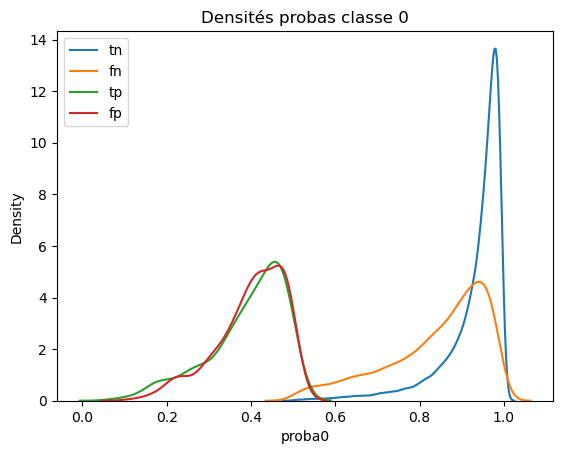

In [28]:
df = resultats_lgbm.copy()
plt.figure()
plt.title('Densités probas classe 0')
sns.kdeplot(df.loc[df.status == 'tn', 'proba0'])
sns.kdeplot(df.loc[df.status == 'fn', 'proba0'])
sns.kdeplot(df.loc[df.status == 'tp', 'proba0'])
sns.kdeplot(df.loc[df.status == 'fp', 'proba0'])

plt.legend(['tn', 'fn', 'tp', 'fp'])
plt.show()

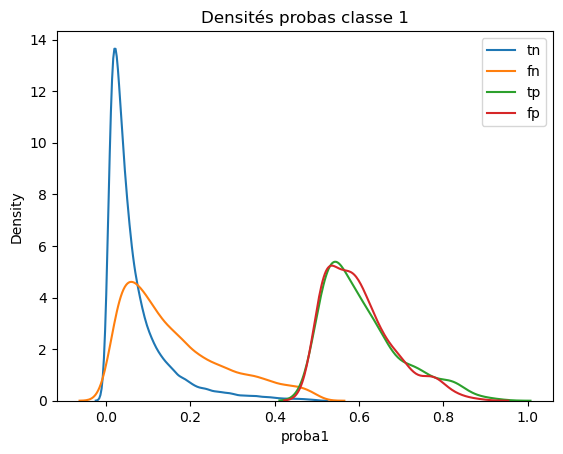

In [29]:
df = resultats_lgbm.copy()
plt.figure()
plt.title('Densités probas classe 1')
sns.kdeplot(df.loc[df.status == 'tn', 'proba1'])
sns.kdeplot(df.loc[df.status == 'fn', 'proba1'])
sns.kdeplot(df.loc[df.status == 'tp', 'proba1'])
sns.kdeplot(df.loc[df.status == 'fp', 'proba1'])
plt.legend(['tn', 'fn', 'tp', 'fp'])
plt.show()

# Test d'ajout d'un 3e modèle (après classif xgb et LightGBM)

In [30]:
# Récup predict proba xgb et lgbo, faire passer dans randomforest
#model = RandomForestClassifier()
XGB_trainPred = xgb.predict_proba(X_train)
LGBM_trainPred = lgbm.predict_proba(X_train)
X2_train = np.concatenate((XGB_trainPred[:,[0]], XGB_trainPred[:,[1]], 
                           LGBM_trainPred[:,[0]], LGBM_trainPred[:,[1]]), axis=1)

2023/08/10 16:18:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [31]:
model = LogisticRegression()
model.fit(X2_train, y_train)
pp1 = xgb.predict_proba(X_test)
pp2 = lgbm.predict_proba(X_test)
X2_test = np.concatenate((pp1[:,[0]], pp1[:,[1]], 
                           pp2[:,[0]], pp2[:,[1]]), axis=1)

# creating the evaluation dataframe
# eval_data = X_test.copy()
eval_data = pd.DataFrame(X2_test)
eval_data['target'] = y_test
evaluation_run('LR_post XGB/LGBM', model)

2023/08/10 16:19:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3263110b922b4f8ba4a92124a70fa65c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/08/10 16:19:15 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'list' object has no attribute 'flatten'
2023/08/10 16:19:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Jessica\anaconda3\lib\site-packages\mlflow\data\pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values

# Ajustement du seuil de positivité?

In [32]:
def metrics_finales(y_true, y_pred) :
    print('Score metier :', scorer_metier(y_true, y_pred))
    print('Recall :', metrics.recall_score(y_true, y_pred))
    print('Precision :', metrics.precision_score(y_true, y_pred))
    print('Accuracy :', metrics.accuracy_score(y_true, y_pred))
    print('CM :', metrics.confusion_matrix(y_true, y_pred))

In [34]:
import mlflow.pyfunc

# Récup du modèle sélectionné et predict
model = mlflow.lightgbm.load_model(model_uri='models:/LightGBM/latest')

# Predict
predictions = model.predict(X_test)
probas = model.predict_proba(X_test)

In [35]:
def correction_allocations(probas, predictions, seuil):
    predictions_corrigees = []
    for i in range(len(probas)): 
        if probas[i][1] > seuil:
            predictions_corrigees.append(1)
        else :
            predictions_corrigees.append(0)
    return predictions_corrigees

predict_corrigees = correction_allocations(probas, predictions, 0.41)
print('--- Predict ---')
metrics_finales(y_test, predictions.tolist())
print('--- Predict corrigé ---')
metrics_finales(y_test, predict_corrigees)

--- Predict ---
Score metier : 0.7689668628662483
Recall : 0.053172205438066465
Precision : 0.4826325411334552
Accuracy : 0.9189619849760984
CM : [[56254   283]
 [ 4701   264]]
--- Predict corrigé ---
Score metier : 0.7377646255406328
Recall : 0.0986908358509567
Precision : 0.4398563734290844
Accuracy : 0.9170921270852981
CM : [[55913   624]
 [ 4475   490]]


In [36]:
# Test de précision, recall et score métiern en fonction du seuil de positivité
recall, precision, metier = [], [], []
seuils = np.arange(0.35,0.61,0.01)
for seuil in seuils: 
    predict_corrigees = correction_allocations(probas, predictions, seuil)
    recall.append(metrics.recall_score(y_test, predict_corrigees))
    precision.append(metrics.precision_score(y_test, predict_corrigees))
    metier.append(scorer_metier(y_test, predict_corrigees))
comparaison_seuils = pd.DataFrame({'seuil' : seuils,
                                  'recall' : recall,
                                  'precision' : precision,
                                  'score' : metier})

comparaison_seuils.head()

,seuil,recall,precision,score
0,0.35,0.146425,0.395969,0.707115
1,0.36,0.135750,0.403835,0.713879
2,0.37,0.127694,0.408769,0.719115
3,0.38,0.120040,0.418539,0.723846
4,0.39,0.112387,0.427914,0.728692


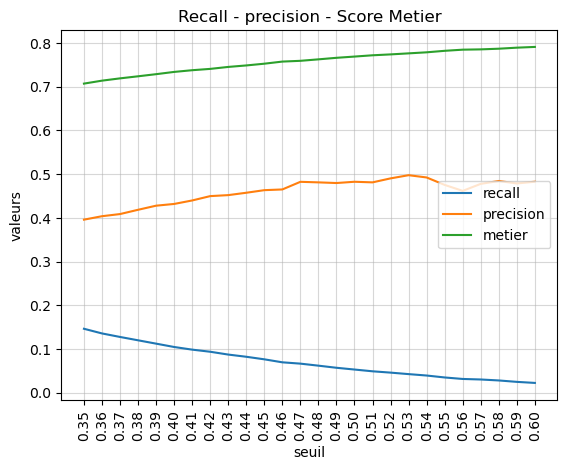

In [42]:
plt.figure()
sns.lineplot(x=comparaison_seuils.seuil, y=comparaison_seuils.recall, label='recall')
sns.lineplot(x=comparaison_seuils.seuil, y=comparaison_seuils.precision, label='precision')
sns.lineplot(x=comparaison_seuils.seuil, y=comparaison_seuils.score, label='metier')
plt.xticks(np.arange(0.35, 0.61, 0.01), rotation=90)
plt.grid(alpha=0.5)
plt.title('Recall - precision - Score Metier')
plt.ylabel('valeurs')
plt.legend()
plt.show()

In [43]:
comparaison_seuils.loc[(comparaison_seuils['recall'] > 0.1) & (comparaison_seuils['precision'] > 0.4)]

,seuil,recall,precision,score
1,0.36,0.135750,0.403835,0.713879
2,0.37,0.127694,0.408769,0.719115
3,0.38,0.120040,0.418539,0.723846
4,0.39,0.112387,0.427914,0.728692
5,0.40,0.104733,0.431894,0.733862


In [44]:
comparaison_seuils.loc[(comparaison_seuils['recall'] > 0.05) & (comparaison_seuils['precision'] > 0.45)]

,seuil,recall,precision,score
8,0.43,0.087412,0.452083,0.745277
9,0.44,0.082377,0.457494,0.748675
10,0.45,0.076536,0.463415,0.752658
11,0.46,0.069688,0.465054,0.757504
12,0.47,0.066667,0.482507,0.759244
13,0.48,0.062034,0.481250,0.762609
14,0.49,0.057200,0.479730,0.766121
15,0.50,0.053172,0.482633,0.768967


> Passer à un seuil de 0.39?

# Features importances

In [45]:
# Feature importance du modèle (importance=split)
model.set_params(importance_type='split')

fi = model.feature_importances_
df_fi = pd.DataFrame({'features' : X_test.columns,
              'importance' : fi}).sort_values(by='importance', ascending=False)
df_fi.head(10)

,features,importance
182,EXT_SOURCE_2,309
362,PAYMENT_RATE,297
183,EXT_SOURCE_3,293
172,DAYS_BIRTH,214
569,REGION_POPULATION_RELATIVE,195
175,DAYS_ID_PUBLISH,159
177,DAYS_REGISTRATION,155
14,AMT_ANNUITY,155
15,AMT_CREDIT,130
173,DAYS_EMPLOYED,127


In [56]:
# Feature importance du modèle (importance=gain)
model.set_params(importance_type='gain')

fi = model.feature_importances_
df_fi = pd.DataFrame({'features' : X_test.columns,
              'importance' : fi}).sort_values(by='importance', ascending=False)
df_fi.head(10)

,features,importance
284,OBS_30_CNT_SOCIAL_CIRCLE,174291.794768
182,EXT_SOURCE_2,146048.130219
171,CODE_GENDER,126500.741871
208,FLAG_OWN_CAR,117206.932275
170,CNT_FAM_MEMBERS,116839.328218
256,NAME_EDUCATION_TYPE_OHE_Secondarysecondaryspecial,102834.707127
253,NAME_EDUCATION_TYPE_OHE_Highereducation,100687.644778
257,NAME_FAMILY_STATUS_OHE_Civilmarriage,91251.653707
169,CNT_CHILDREN,83331.147784
272,NAME_INCOME_TYPE_OHE_Pensioner,75564.578457


## SHAP

TEST
model1 = lgbm
model_final = pipe(si:model1, step2 fct reclass)

In [48]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


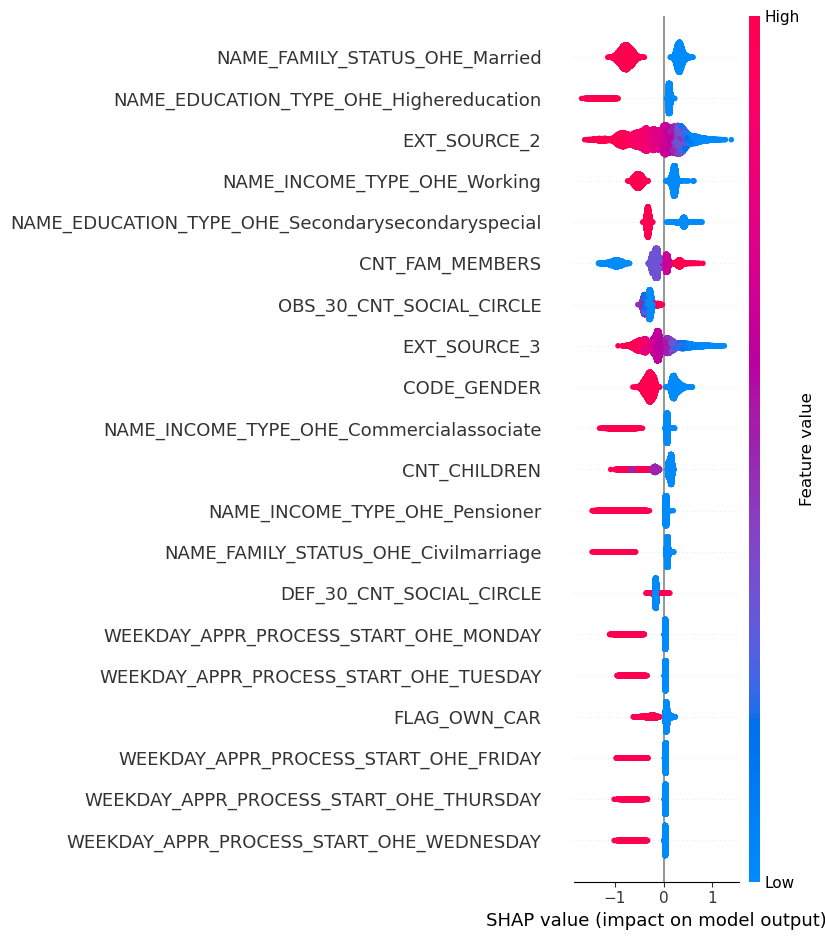

In [49]:
shapv = shap_values[:, :, 1]
shap.summary_plot(shapv, X_test)

## FI test locales (pour différents types de clients)

In [50]:
test_data = X_test.copy().reset_index()
test_data['target'] = y_test
test_data['predict'] = correction_allocations(probas, predictions, 0.39)

True POS
50240


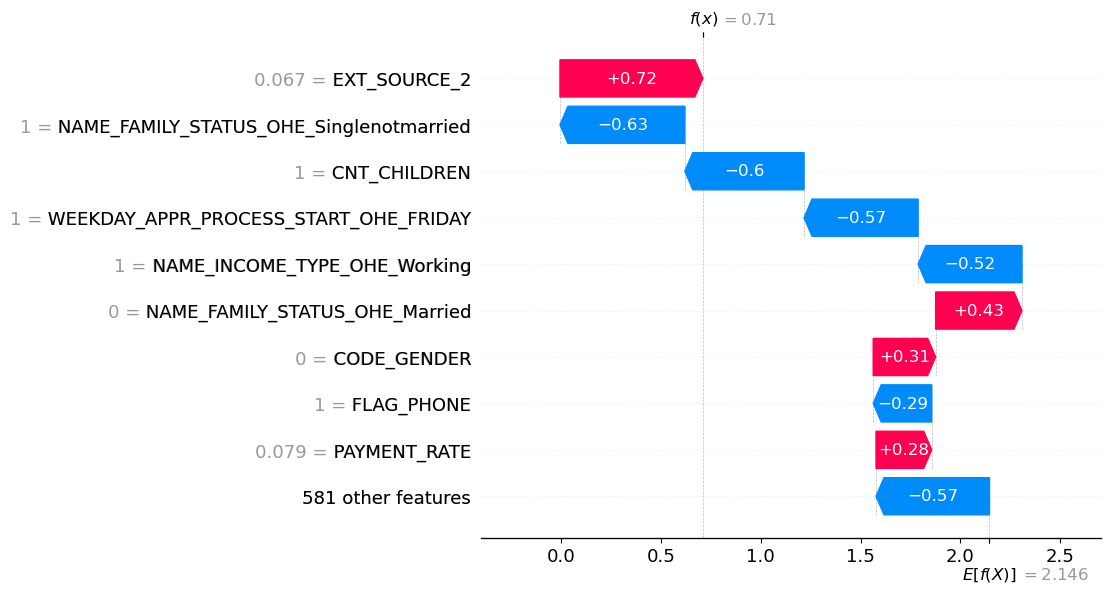

In [51]:
print('True POS')
client_TP = test_data.loc[(test_data['target'] == 1) & (test_data['predict'] == 1)].sample(n=1)
idx = client_TP.index[0]
print(idx)
shap.plots.waterfall(shapv[idx])

True NEG
48862


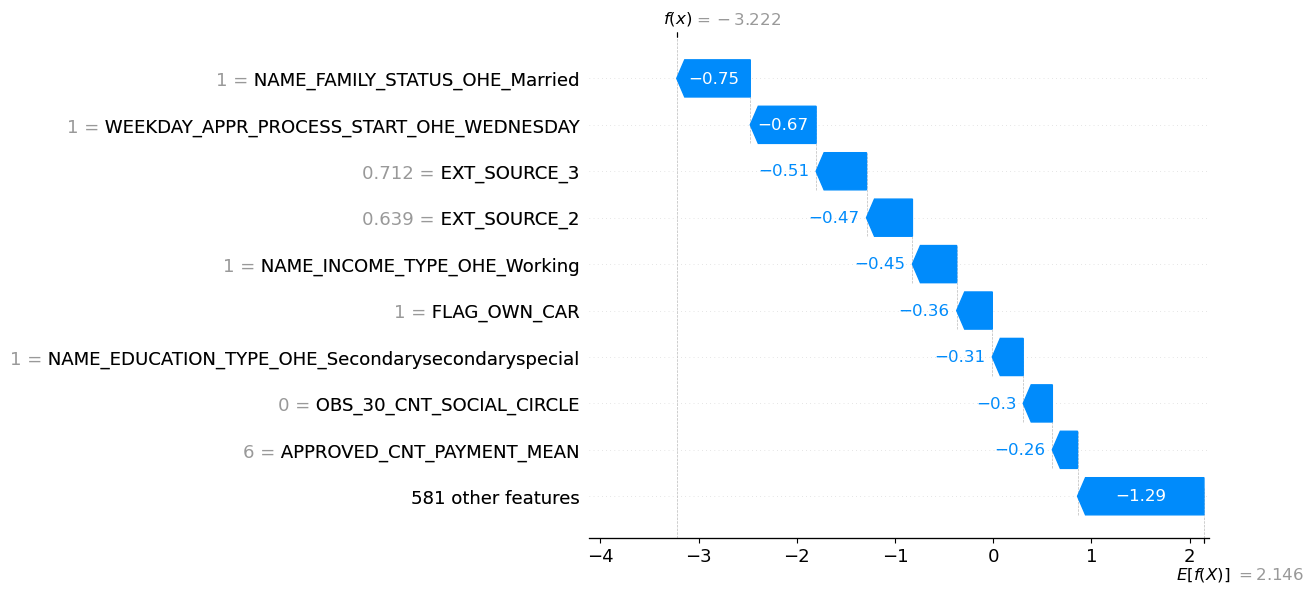

In [52]:
print('True NEG')
client_TN = test_data.loc[(test_data['target'] == 0) & (test_data['predict'] == 0)].sample(n=1)
idx = client_TN.index[0]
print(idx)
shap.plots.waterfall(shapv[idx])

False POS
42832


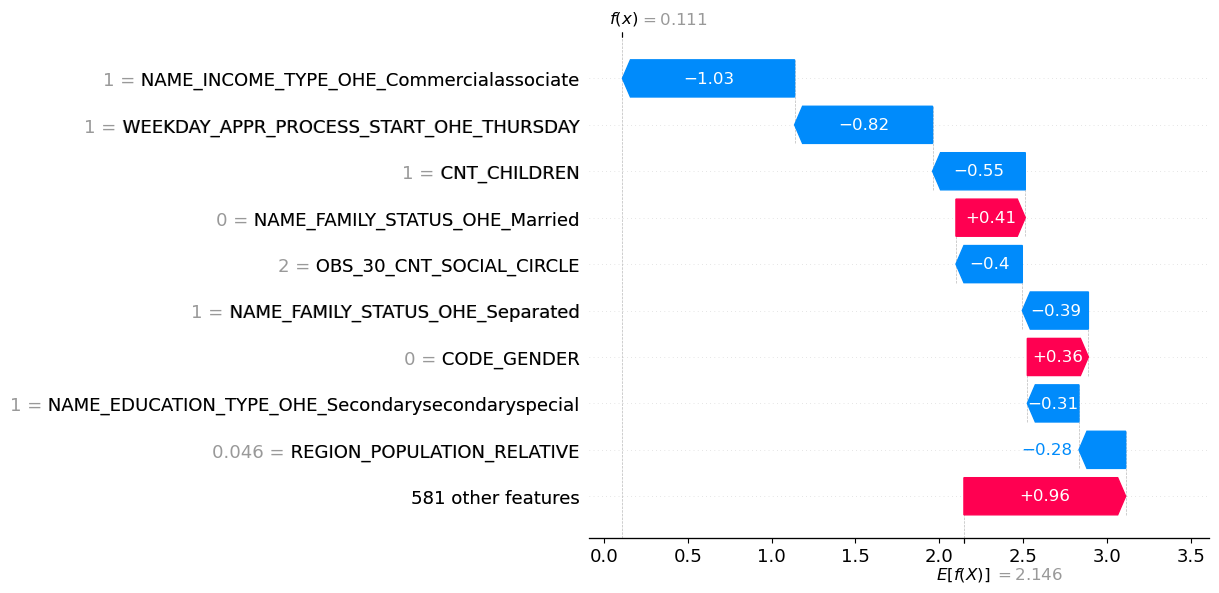

In [61]:
print('False POS')
client_FP = test_data.loc[(test_data['target'] == 0) & (test_data['predict'] == 1)].sample(n=1)
idx = client_FP.index[0]
print(idx)
shap.plots.waterfall(shapv[idx])

False NEG
15007


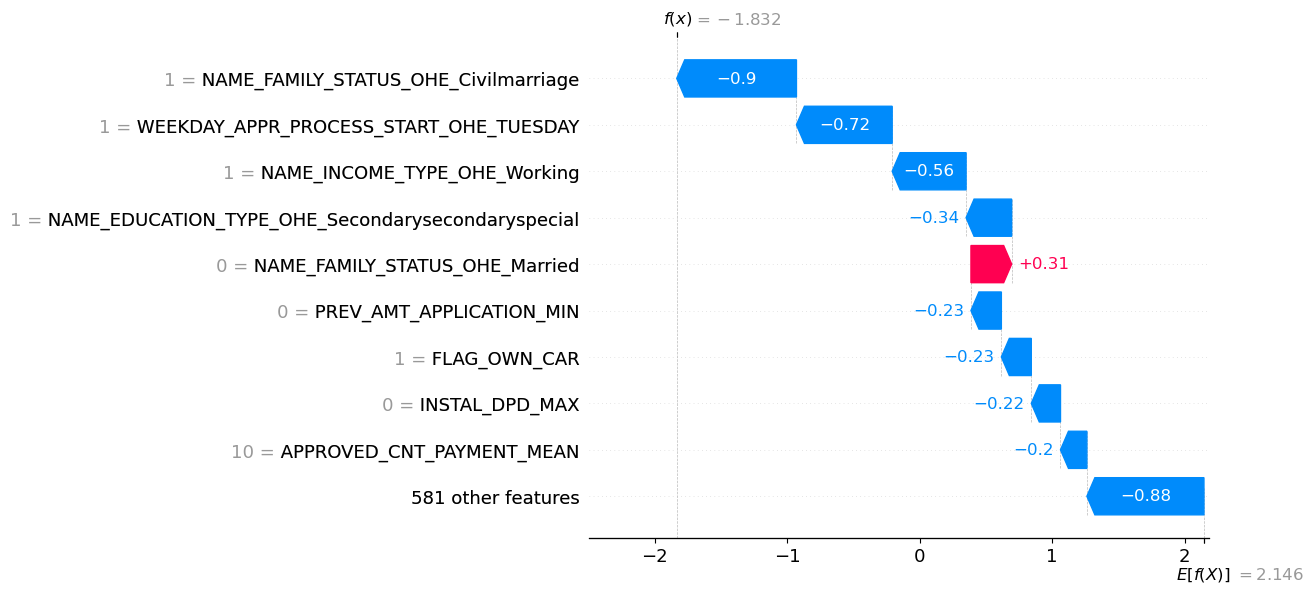

In [54]:
print('False NEG')
client_FN = test_data.loc[(test_data['target'] == 1) & (test_data['predict'] == 0)].sample(n=1)
idx = client_FN.index[0]
print(idx)
shap.plots.waterfall(shapv[idx])

### Test modif feature
(faux positif)

In [55]:
id_cli_test = 4562
print('True : ', test_data.loc[id_cli_test, 'target'])
print('Predict : ', test_data.loc[id_cli_test, 'predict'])
cli = pd.DataFrame(test_data.loc[id_cli_test].drop(['target', 'predict', 'SK_ID_CURR'])).T
print('Payment rate : ', cli['PAYMENT_RATE'])
cli['PAYMENT_RATE'] = 0.01
print('New payment rate : ', cli['PAYMENT_RATE'].values[0])
new_pred = model.predict(cli)
print('New prediction :', new_pred)

True :  0
Predict :  1
Payment rate :  4562    0.068269
Name: PAYMENT_RATE, dtype: float64
New payment rate :  0.01
New prediction : [0]
